In [ ]:
# default_exp main
from nbdev import *
from utilities.ipynb_docgen import *
import pandas as pd
import matplotlib.pyplot as plt
!date

Tue Oct  5 08:44:30 PDT 2021


# wtlike interface
> Top-level interface to the rest of the package

In [ ]:
# export
import numpy as np
from wtlike.bayesian import get_bb_partition
from wtlike.lightcurve import fit_cells, LightCurve, flux_plot
from wtlike.cell_data import partition_cells
from wtlike.config import *


class WtLike(LightCurve):
    """
    Summary
    ---------
    There are three layers of initialization, implemented in superclasses,
    each with parameters. The classnames, associated parameters and data members set:

    SourceData -- load photons and exposure
        parameters:
          - source : name, a PointSource object, or a Simulation object
          - config [Config()] : basic configuration
          - week_range [None] : range of weeks to load
          - key [''] : the cache key: '' means construct one with the source name, None to disable
          - clear [False] : if using cache, clear the contents first
        sets:
          - photons
          - exposure

    CellData -- create cells
        parameters:
          - time_bins [Config().time_bins] : binning: start, stop, binsize
        sets:
          - cells

    LightCurve -- likelihood analysis of the cells
        parameters:
          - e_min [10] -- threshold for exposure (cm^2 units)
          - n_min [2]  -- likelihood has trouble with this few
          - lc_key [None] -- possible cache for light curve
        sets:
          - fits, fluxes

    WtLike (this class) -- no parameters (may add BB-specific ones)
        Implements:  bb_view, plot_BB
        sets:
          - bb_flux  (only if bb_view invoked)

    """
    def bb_view(self, p0=0.05, key=None, clear=False):
        """Return a view with the BB analysis applied

        - p0 -- false positive probability parameter

        Its `plot` function will by default show an overplot on the parent's data points.
        """
        #  a new instance
        r = self.view()

        # bb analysis on this to make new  set of cells and poisson fits
        bb_edges  = get_bb_partition(self.config, self.fits,  p0=p0, key=key, clear=clear)
        r.cells = partition_cells(self.config, self.cells, bb_edges)

        r.fits = fit_cells(self.config, r.cells, )
        r.isBB = True
        r.bayes_p0 = p0
        return r

    def plot(self, *pars, **kwargs):
        # which view type is this?
        if getattr(self, 'isBB', False):
            return self.plot_bb(*pars, **kwargs)
        elif getattr(self, 'is_phase', False):
            return self.plot_phase(*pars, **kwargs)
        else:
            return super().plot(*pars, **kwargs)

    def plot_bb(self, ax=None, **kwargs):
        """Plot the light curve with BB overplot
        """
        import matplotlib.pyplot as plt
        self.check_plot_kwargs(kwargs)
        figsize = kwargs.pop('figsize', (12,4))
        fignum = kwargs.pop('fignum', 1)
        ts_min = kwargs.pop('ts_min',-1)
        source_name =kwargs.pop('source_name', self.source_name)
        fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)


        colors = kwargs.pop('colors', ('lightblue', 'wheat', 'blue') )
        flux_plot(self.parent.fits, ax=ax, colors=colors, source_name=source_name,
                  label=self.step_name+' bins', **kwargs)
        flux_plot(self.fits, ax=ax, step=True,
                  label=f'BB (p0={100*self.bayes_p0:.0f}%)', zorder=10,**kwargs)
        ax.grid(alpha=0.5)
        fig.set_facecolor('white')
        return fig
    
    def phase_view(self, period, nbins=25, reference='2008'):
        """ Return a "phase" view, in which the cell time binning is according to phase.
        
        * reference -- a UTC date for aligning the bins.
        """
        ref = 0 if not reference else MJD(reference)
        
        # helper function that returns the bin number as a float in [0,period)
        binner = lambda t: np.mod(t-ref,period)/period * nbins

        # adjust start to correspond to edge of bin

        # create a view with nbins per period and get the cells
        st = self.start # the start of data taking
        self.reference_bin =strefbin = binner(st)
        stnew = st +np.mod(-strefbin,1)*period/nbins
        view = self.view(stnew, 0, period/nbins)
        cells = view.cells
        bw = 1/nbins

        def concat(pcells, t):
            newcell = dict(t=t, tw=bw)
            for col in 'n e S B'.split():
                newcell[col] = pcells[col].sum()
            newcell['w'] = np.concatenate(list(pcells.w.values))
            return newcell

        # concatenate all in the same phase bin--note cyclic rotation
        k = int(strefbin)
        fcells = [concat(cells.iloc[((ibin-k)%nbins):-1:nbins], (ibin+0.5)*bw)  for ibin in range(nbins) ]
        
        view.cells = pd.DataFrame(fcells) 
        view.update()
        view.is_phase = True
        view.period = period
        return  view
    
    def plot_phase(self, ax=None, **kwargs):
        """Plot a phase lightcurve
    
        """
        kw = dict(ylim=(0.975, 1.025), xlim=(0,1) )
        kw.update(kwargs)
        fig, ax = plt.subplots(figsize=(10,5)) if ax is None else (ax.figure, ax)
        fig = super().plot(ax=ax, xlabel=f'phase for {self.period}-day period'); 
        ax.set(**kwargs );
        ax.axhline(1.0, color='grey');
        return fig

In [ ]:
#collapse_input
def phase_tests():
    """
    ### Test phase_view
    {out1}
    
    {fig1}
    {out2}
    {fig2}
    """
    plt.rc('font', size=16)
    year = 365.25; ref_date='2008'; precess=53.05

    with capture(f'Vela setup, {precess}-day period') as out1:
        vela = WtLike('Vela pulsar')
        pv = vela.phase_view( period=precess, nbins=25); 
    fig1 = figure(pv.plot(), width=500);

    with capture(f'Geminga setup: period={year} days, relative to {ref_date}') as out2:
        geminga = WtLike('Geminga')
        gv = geminga.phase_view(year, nbins=50, reference=ref_date)
    fig2 = figure(gv.plot(), width=500)    

#     #gv.fluxes.query('flux>1.07')
#     with capture(f'Geminga with yearly bins') as out3:
#         gt = geminga.view(54685.15, 0, 7.305)
#     fig3= figure(gt.plot(UTC=True));
#     fq = gt.fluxes.query('flux>1.1')['t flux'.split()];
    return locals()

if Config().valid:
    nbdoc(phase_tests)

### Test phase_view
<details  class="nbdoc-description" >  <summary> Vela setup, 53.05-day period </summary>  <div style="margin-left: 5%;"><pre>SourceData:  PSR J0835-4510: Restoring from cache with key "PSR J0835-4510_data"<br>SourceData: Source Vela pulsar with:<br>	 data:     3,368,394 photons from 2008-08-04 to 2021-09-01<br>	 exposure: 3,072,837 intervals,  average effective area 3541 cm^2 for 91.8 Ms<br>	 rates:  source 8.36e-06/s, background 2.00e-06/s, TS 7052015.5<br>CellData: Bin photon data into 682 1-week bins from 54683.0 to 59457.0<br>LightCurve: select 674 cells for fitting with e&gt;35 & n&gt;2<br>CellData: Bin photon data into 2249 2.1-day bins from 54684.6 to 59456.9<br>LightCurve: select 2192 cells for fitting with e&gt;10.61 & n&gt;2<br>LightCurve: select 25 cells for fitting with e&gt;10.61 & n&gt;2<br></pre></div> </details>

<figure style="margin-left: 5%" title="Figure 1">  <a href="images/phase_tests_fig_01.png" title="images/phase_tests_fig_01.png">    <img src="images/phase_tests_fig_01.png" alt="Figure 1 at images/phase_tests_fig_01.png" width=500>   </a> </figure>
<details  class="nbdoc-description" >  <summary> Geminga setup: period=365.25 days, relative to 2008 </summary>  <div style="margin-left: 5%;"><pre>SourceData:  4FGL J0633.9+1746: Restoring from cache with key "PSR J0633+1746_data"<br>SourceData: Source Geminga with:<br>	 data:     1,139,632 photons from 2008-08-04 to 2021-09-01<br>	 exposure: 3,189,511 intervals,  average effective area 2775 cm^2 for 95.4 Ms<br>	 rates:  source 3.22e-06/s, background 1.08e-06/s, TS 2290923.9<br>CellData: Bin photon data into 682 1-week bins from 54683.0 to 59457.0<br>LightCurve: select 667 cells for fitting with e&gt;35 & n&gt;2<br>CellData: Bin photon data into 653 7.3-day bins from 54685.2 to 59455.3<br>LightCurve: select 642 cells for fitting with e&gt;36.525 & n&gt;2<br>LightCurve: select 50 cells for fitting with e&gt;36.525 & n&gt;2<br></pre></div> </details>
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/phase_tests_fig_02.png" title="images/phase_tests_fig_02.png">    <img src="images/phase_tests_fig_02.png" alt="Figure 2 at images/phase_tests_fig_02.png" width=500>   </a> </figure>


In [ ]:
show_doc(WtLike)
show_doc(WtLike.bb_view)
show_doc(WtLike.phase_view)

<h2 id="WtLike" class="doc_header"><code>class</code> <code>WtLike</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>WtLike</code>(**\*`pars`**, **\*\*`kwargs`**) :: [`LightCurve`](/wtlikelightcurve.html#LightCurve)

Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- possible cache for light curve
    sets:
      - fits, fluxes

WtLike (this class) -- no parameters (may add BB-specific ones)
    Implements:  bb_view, plot_BB
    sets:
      - bb_flux  (only if bb_view invoked)

<h4 id="WtLike.bb_view" class="doc_header"><code>WtLike.bb_view</code><a href="__main__.py#L47" class="source_link" style="float:right">[source]</a></h4>

> <code>WtLike.bb_view</code>(**`p0`**=*`0.05`*, **`key`**=*`None`*, **`clear`**=*`False`*)

Return a view with the BB analysis applied

- p0 -- false positive probability parameter

Its `plot` function will by default show an overplot on the parent's data points.

<h4 id="WtLike.phase_view" class="doc_header"><code>WtLike.phase_view</code><a href="__main__.py#L96" class="source_link" style="float:right">[source]</a></h4>

> <code>WtLike.phase_view</code>(**`period`**, **`nbins`**=*`25`*, **`reference`**=*`'2008'`*)

Return a "phase" view, in which the cell time binning is according to phase.

* reference -- a UTC date for aligning the bins.

SourceData:  4FGL J0633.9+1746
LoadData: Loading weeks[9:108:]	Processing 100 week files, using 4 processes ....................................................................................................

SourceData: Source Geminga with:
	 data:       191,086 photons from 2008-08-04 to 2010-07-01
	 exposure:   498,346 intervals,  average effective area 2890 cm^2 for 14.9 Ms
	 rates:  source 3.33e-06/s, background 1.11e-06/s, TS 2290923.9
CellData: Bin photon data into 99 1-week bins from 54683.0 to 55376.0
LightCurve: select 99 cells for fitting with e>35 & n>2
Bayesian Blocks: partitioning 99 cells using LikelihoodFitness with penalty 5%
	found 3 / 99 blocks.
LightCurve: Loaded 3 / 3 cells for fitting


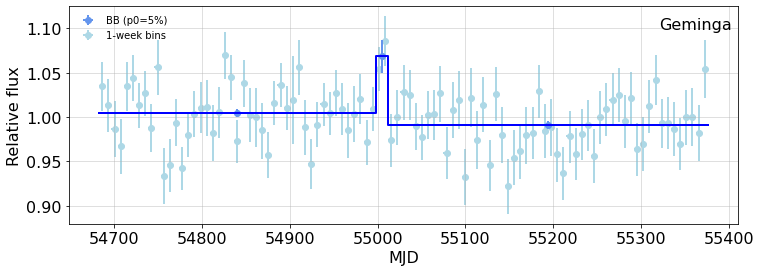

In [ ]:
#hide
from wtlike.config import *
config = Config()
if config.valid:
    wtl = WtLike('Geminga', week_range=(9,108) )
    wtl.bb_view().plot();

In [ ]:
#collapse_input
full = None
# code for the demo--this shouid be collapsed
def demo(clear=False):
    """
    ## Test/Demonstration with 3C 279
    
    > Note that this also demonstrates using `nbdoc` to have a single Jupyterlab cell generate a document
    
    First, the weekly light curve:
    {out1}    {fig1}
    
    Replot the figure with an expanded scale to see position of a flare:
    {fig2}
    {out3}    {fig3}
    {out4}    {fig4}
    
    Table of BB fits
    {bb_table}
    
    This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
    {kerr_fig4}
    """
    global full
    
    #with capture_print('Create full weekly light curve') as out1:
    full = WtLike('3C 279', clear=clear)
    
    fig1 = figure(
        full.plot(yscale='log', ylim=(0.2,20), figsize=(15,5), xlabel='MJD', fmt='.', fignum=1),
        caption='Full scale', width=600)  
    
    fig2 = figure(
        full.plot(  figsize=(15,5), xlabel='MJD', fmt='o', fignum=2,  xlim=(57100, 57300),),
        width=600)  
    
    with capture_print('Define orbit-based subset around large flare at MJD 57189') as out3:
        orbit = full.view((57186, 57191, 0))
    fig3 = figure(
        orbit.plot(fmt='o', tzero=57186,   fignum=3 ),
            width=600)
    
    with capture_print('Apply BB and overplot it with the cells on which it is based') as out4:
        bborbit = orbit.bb_view()
    fig4 = figure(
        bborbit.plot(fmt='o', tzero=57186,   fignum=4),
                width=600)
    
    bb_table = orbit.fluxes
    
    kerr_fig4 = image('kerr_fig4.png', width=600, caption=None)
    return locals()

if config.valid:
    nbdoc(demo, False)

SourceData:  4FGL J1256.1-0547: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       182,684 photons from 2008-08-04 to 2021-09-11
	 exposure: 2,896,631 intervals,  average effective area 2847 cm^2 for 86.5 Ms
	 rates:  source 3.95e-07/s, background 3.47e-07/s, TS 183590.9
CellData: Bin photon data into 683 1-week bins from 54683.0 to 59464.0
LightCurve: select 672 cells for fitting with e>35 & n>2


/home/burnett/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Test/Demonstration with 3C 279

> Note that this also demonstrates using `nbdoc` to have a single Jupyterlab cell generate a document

First, the weekly light curve:
{out1}    <figure style="margin-left: 5%" title="Figure 1">  <a href="images/demo_fig_01.png" title="images/demo_fig_01.png">    <img src="images/demo_fig_01.png" alt="Figure 1 at images/demo_fig_01.png" width=600>   </a>  <figcaption><b>Figure 1</b>. Full scale</figcaption></figure>

Replot the figure with an expanded scale to see position of a flare:
<figure style="margin-left: 5%" title="Figure 2">  <a href="images/demo_fig_02.png" title="images/demo_fig_02.png">    <img src="images/demo_fig_02.png" alt="Figure 2 at images/demo_fig_02.png" width=600>   </a> </figure>
<details  class="nbdoc-description" >  <summary> Define orbit-based subset around large flare at MJD 57189 </summary>  <div style="margin-left: 5%;"><pre>CellData: Bin photon data into 80 orbit-based bins from 57186.1 to 57191.0<br>LightCurve: select 62 cells for fitting with e&gt;0 & n&gt;2<br></pre></div> </details>    <figure style="margin-left: 5%" title="Figure 3">  <a href="images/demo_fig_03.png" title="images/demo_fig_03.png">    <img src="images/demo_fig_03.png" alt="Figure 3 at images/demo_fig_03.png" width=600>   </a> </figure>
<details  class="nbdoc-description" >  <summary> Apply BB and overplot it with the cells on which it is based </summary>  <div style="margin-left: 5%;"><pre>Bayesian Blocks: partitioning 62 cells using LikelihoodFitness with penalty 5%<br>	found 10 / 62 blocks.<br>LightCurve: Loaded 10 / 10 cells for fitting<br></pre></div> </details>    <figure style="margin-left: 5%" title="Figure 4">  <a href="images/demo_fig_04.png" title="images/demo_fig_04.png">    <img src="images/demo_fig_04.png" alt="Figure 4 at images/demo_fig_04.png" width=600>   </a> </figure>

Table of BB fits
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>t</th>
      <th>tw</th>
      <th>n</th>
      <th>e</th>
      <th>ts</th>
      <th>flux</th>
      <th>errors</th>
      <th>limit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>57186.116</td>
      <td>0.017</td>
      <td>5</td>
      <td>4.569</td>
      <td>12.600</td>
      <td>1.820</td>
      <td>(-0.892, 1.291)</td>
      <td>4.739</td>
    </tr>
    <tr>
      <td>57186.253</td>
      <td>0.025</td>
      <td>9</td>
      <td>6.530</td>
      <td>15.500</td>
      <td>2.458</td>
      <td>(-0.967, 1.244)</td>
      <td>5.014</td>
    </tr>
    <tr>
      <td>57186.385</td>
      <td>0.026</td>
      <td>9</td>
      <td>6.564</td>
      <td>16.300</td>
      <td>2.625</td>
      <td>(-0.994, 1.262)</td>
      <td>5.192</td>
    </tr>
    <tr>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <td>57190.831</td>
      <td>0.012</td>
      <td>9</td>
      <td>4.590</td>
      <td>27.600</td>
      <td>4.047</td>
      <td>(-1.413, 1.794)</td>
      <td>7.696</td>
    </tr>
    <tr>
      <td>57190.898</td>
      <td>0.009</td>
      <td>3</td>
      <td>3.417</td>
      <td>7.700</td>
      <td>1.932</td>
      <td>(-1.038, 1.538)</td>
      <td>5.468</td>
    </tr>
    <tr>
      <td>57190.966</td>
      <td>0.006</td>
      <td>3</td>
      <td>2.182</td>
      <td>2.200</td>
      <td>1.979</td>
      <td>(-1.506, 2.323)</td>
      <td>7.520</td>
    </tr>
  </tbody>
</table>
</div>

This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
<figure style="margin-left: 5%" title="Figure 5">  <a href="images/demo_fig_05.png" title="images/demo_fig_05.png">    <img src="images/demo_fig_05.png" alt="Figure 5 at images/demo_fig_05.png" width=600>   </a> </figure>


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Tue Oct  5 08:45:08 PDT 2021
